## ImageNet using AlexNet 

In [1]:
import keras
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
import os
import numpy as np
from PIL import Image
from keras.regularizers import l2

Using TensorFlow backend.


In [2]:
from google.colab import files
uploaded=files.upload()

Saving tiny-imagenet-200.zip to tiny-imagenet-200.zip


In [0]:
def get_annotations_map():
    valAnnotationsPath = 'tiny-imagenet-200/val/val_annotations.txt'
    valAnnotationsFile = open(valAnnotationsPath, 'r')
    valAnnotationsContents = valAnnotationsFile.read()
    valAnnotations = {}

    for line in valAnnotationsContents.splitlines():
        pieces = line.strip().split()
        valAnnotations[pieces[0]] = pieces[1]

    return valAnnotations

In [0]:
import zipfile,io
data = zipfile.ZipFile(io.BytesIO(uploaded['tiny-imagenet-200.zip']),'r')
data.extractall()

In [28]:
train_data_dir = 'tiny-imagenet-200/train'
validation_data_dir = 'tiny-imagenet-200/val'
test_data_dir = 'tiny-imagenet-200/test'
target_names = [item for item in os.listdir(train_data_dir) if os.path.isdir(os.path.join(train_data_dir, item))]
nb_train_samples = sum([len(files) for _,_ , files in os.walk(train_data_dir)])
nb_validation_samples = sum([len(files) for _,_ , files in os.walk(validation_data_dir)])
nb_test_samples = sum([len(files) for _,_ , files in os.walk(test_data_dir)])
total_nb_samples = nb_train_samples + nb_validation_samples + nb_test_samples

nb_classes = len(target_names)      # number of output classes

print('Training a CNN Multi-Classifier Model ......')
print('\n - names of classes: ', target_names, '\n - # of classes: ', nb_classes)
print(' - # of trained samples: ', nb_train_samples, '\n - # of validation samples: ', nb_validation_samples,
     '\n - # of test samples: ', nb_test_samples,
      '\n - total # of samples: ', total_nb_samples, '\n - train ratio:', round(nb_train_samples/total_nb_samples*100, 2),
     '\n - validation ratio:', round(nb_validation_samples/total_nb_samples*100, 2),
     '\n - test ratio:', round(nb_test_samples/total_nb_samples*100, 2),
    ' %', '\n - # of epochs: ', 2, '\n - batch size: ', 500)

Training a CNN Multi-Classifier Model ......

 - names of classes:  ['n02129165', 'n03837869', 'n01742172', 'n03250847', 'n03126707', 'n02815834', 'n04532670', 'n03854065', 'n12267677', 'n07615774', 'n03649909', 'n03584254', 'n02226429', 'n02423022', 'n03014705', 'n09332890', 'n03617480', 'n02206856', 'n03763968', 'n03201208', 'n01774384', 'n01698640', 'n01944390', 'n04507155', 'n04532106', 'n03400231', 'n03796401', 'n04259630', 'n02883205', 'n02403003', 'n03976657', 'n02837789', 'n04251144', 'n02123045', 'n02795169', 'n01855672', 'n02124075', 'n04540053', 'n04067472', 'n04560804', 'n02056570', 'n01983481', 'n02486410', 'n07920052', 'n04074963', 'n04376876', 'n04118538', 'n04465501', 'n03838899', 'n03404251', 'n04597913', 'n02988304', 'n03160309', 'n02504458', 'n04417672', 'n02410509', 'n02909870', 'n06596364', 'n07734744', 'n03983396', 'n02480495', 'n02281406', 'n04371430', 'n03662601', 'n03544143', 'n07875152', 'n03937543', 'n02927161', 'n01644900', 'n07720875', 'n02841315', 'n026994

In [0]:


def load_images(path,num_classes):
    #Load images
    
    print('Loading ' + str(num_classes) + ' classes')

    X_train=np.zeros([num_classes*500,3,32,32],dtype='uint8')
    y_train=np.zeros([num_classes*500], dtype='uint8')
    
    print('loading training images...');
    trainPath=path+'/train'

    i=0
    j=0
    annotations={}
    for sChild in os.listdir(trainPath):
        sChildPath = os.path.join(os.path.join(trainPath,sChild),'images')
        annotations[sChild]=j
        for c in os.listdir(sChildPath):
            X=np.array(Image.open(os.path.join(sChildPath,c)))
            if len(np.shape(X))==2:
                X_train[i]=np.array([X,X,X])
            else:
                X_train[i]=np.transpose(X,(2,0,1))
            y_train[i]=j
            i+=1
        j+=1
        if (j >= num_classes):
            break

    print('finished loading training images')

    val_annotations_map = get_annotations_map()

    X_test = np.zeros([num_classes*50,3,32,32],dtype='uint8')
    y_test = np.zeros([num_classes*50], dtype='uint8')


    print('loading test images...')

    i = 0
    valPath=path+ '/val/images'
    for sChild in os.listdir(valPath):
        if val_annotations_map[sChild] in annotations.keys():
            sChildPath = os.path.join(valPath, sChild)
            X=np.array(Image.open(sChildPath))
            if len(np.shape(X))==2:
                X_test[i]=np.array([X,X,X])
            else:
                X_test[i]=np.transpose(X,(2,0,1))
            y_test[i]=annotations[val_annotations_map[sChild]]
            i+=1
        else:
            pass


    print('finished loading test images')#+str(i)

    return X_train,y_train,X_test,y_test

In [32]:
path=r'tiny-imagenet-200/'
X_train,y_train,X_test,y_test=load_images(path,200)#input data path & numbers of classes

Loading 200 classes
loading training images...
finished loading training images
loading test images...
finished loading test images


### Data Normalization

In [0]:
X_train = X_train.astype('float32') 
X_test = X_test.astype('float32') 
X_train = X_train / 255.0 
X_test = X_test / 255.0

In [0]:
# one hot encode outputs 
y_train = np_utils.to_categorical(y_train) 
y_test = np_utils.to_categorical(y_test) 
num_classes = y_test.shape[1]

## Designing the AlexNet for images of size 32x32

In [0]:
    
    alexnet = Sequential()
    l2_reg = 0.
    # Layer 1
    alexnet.add(Conv2D(96, (11, 11), input_shape=(3,32,32),
                       padding='same', kernel_regularizer=l2(l2_reg)))
    alexnet.add(BatchNormalization())
    alexnet.add(Activation('relu'))
    #alexnet.add(MaxPooling2D(pool_size=(2, 2)))

    # Layer 2
    alexnet.add(Conv2D(256, (5, 5), padding='same'))
    alexnet.add(BatchNormalization())
    alexnet.add(Activation('relu'))
    alexnet.add(MaxPooling2D(pool_size=(2, 2)))
    alexnet.add(Dropout(0.3))

    # Layer 3
    alexnet.add(ZeroPadding2D((1, 1)))
    alexnet.add(Conv2D(512, (3, 3), padding='same'))
    alexnet.add(BatchNormalization())
    alexnet.add(Activation('relu'))
    alexnet.add(MaxPooling2D(pool_size=(2, 2)))
    alexnet.add(Dropout(0.3))
    
    # Layer 4
    alexnet.add(ZeroPadding2D((1, 1)))
    alexnet.add(Conv2D(1024, (3, 3), padding='same'))
    alexnet.add(BatchNormalization())
    alexnet.add(Activation('relu'))
    alexnet.add(Dropout(0.5))
    
    # Layer 5
    alexnet.add(ZeroPadding2D((1, 1)))
    alexnet.add(Conv2D(1024, (3, 3), padding='same'))
    alexnet.add(BatchNormalization())
    alexnet.add(Activation('relu'))
    alexnet.add(MaxPooling2D(pool_size=(2, 2)))

    # Layer 6
    alexnet.add(Flatten())
    alexnet.add(Dense(3072))
    alexnet.add(BatchNormalization())
    alexnet.add(Activation('relu'))
    alexnet.add(Dropout(0.5))

    # Layer 7
    alexnet.add(Dense(4096))
    alexnet.add(BatchNormalization())
    alexnet.add(Activation('relu'))
    alexnet.add(Dropout(0.5))

    # Layer 8
    alexnet.add(Dense(200))
    alexnet.add(BatchNormalization())
    alexnet.add(Activation('softmax'))


In [41]:
alexnet.summary()

epoch = 50
learn_rate = 0.0001
dec = learn_rate /epoch
adam=keras.optimizers.Adam(learn_rate)
# Compile the model
alexnet.compile(loss=keras.losses.categorical_crossentropy,optimizer=adam, metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 3, 32, 96)         371808    
_________________________________________________________________
batch_normalization_17 (Batc (None, 3, 32, 96)         384       
_________________________________________________________________
activation_17 (Activation)   (None, 3, 32, 96)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 3, 32, 256)        614656    
_________________________________________________________________
batch_normalization_18 (Batc (None, 3, 32, 256)        1024      
_________________________________________________________________
activation_18 (Activation)   (None, 3, 32, 256)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 1, 16, 256)        0         
__________

In [42]:
history = alexnet.fit(X_train,y_train,epochs=epoch, validation_data=(X_test, y_test),batch_size=256) 
# Final evaluation of the model 
scores = alexnet.evaluate(X_test, y_test, verbose=2) 
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 100000 samples, validate on 10000 samples
Epoch 1/50
100000/100000 [==============================] - 212s 2ms/step - loss: 5.1860 - acc: 0.0182 - val_loss: 5.7350 - val_acc: 0.0139
Epoch 2/50
100000/100000 [==============================] - 209s 2ms/step - loss: 4.8049 - acc: 0.0446 - val_loss: 5.9468 - val_acc: 0.0176
Epoch 3/50
100000/100000 [==============================] - 209s 2ms/step - loss: 4.6236 - acc: 0.0680 - val_loss: 5.5347 - val_acc: 0.0247
Epoch 4/50
100000/100000 [==============================] - 209s 2ms/step - loss: 4.4646 - acc: 0.0873 - val_loss: 4.7166 - val_acc: 0.0634
Epoch 5/50
100000/100000 [==============================] - 208s 2ms/step - loss: 4.3465 - acc: 0.1044 - val_loss: 4.6553 - val_acc: 0.0691
Epoch 6/50
100000/100000 [==============================] - 209s 2ms/step - loss: 4.2468 - acc: 0.1195 - val_loss: 4.5214 - val_acc: 0.0900
Epoch 7/50
100000/100000 [==============================] - 209s 2ms/step - loss: 4.1523 - acc: 0.1327 - val_

In [0]:
def plotter(trained_record):
    # Loss Curves
    plt.figure(figsize=[8,6])
    plt.plot(trained_record.history['loss'],'r',linewidth=3.0)
    plt.plot(trained_record.history['val_loss'],'b',linewidth=3.0)
    plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
    plt.xlabel('Epochs ',fontsize=16)
    plt.ylabel('Loss',fontsize=16)
    plt.title('Loss Curves',fontsize=16)
    plt.savefig('try1.png')
    # Accuracy Curves
    plt.figure(figsize=[8,6])
    plt.plot(trained_record.history['acc'],'r',linewidth=3.0)
    plt.plot(trained_record.history['val_acc'],'b',linewidth=3.0)
    plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
    plt.xlabel('Epochs ',fontsize=16)
    plt.ylabel('Accuracy',fontsize=16)
    plt.title('Accuracy Curves',fontsize=16)

    plt.savefig('try2.png')

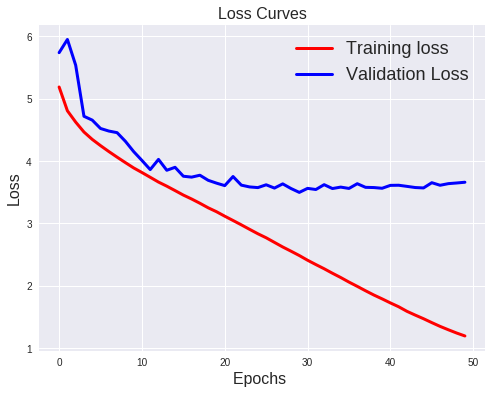

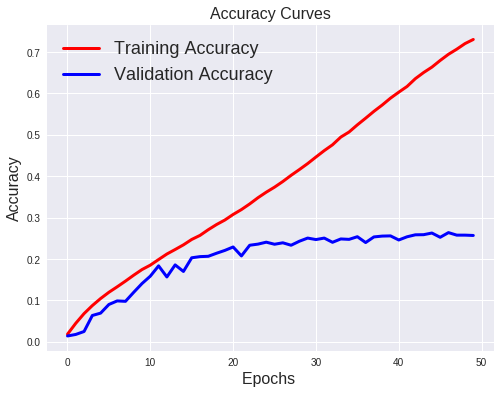

In [44]:
plotter(history)

### Conclusion

Reducing the number of neurons did not improve the performance of CNN classification model. So we can reject thethe hypothesis that the model would perform better after reducing the number of neurons because the model is giving similar performace as that of actual neural network. Model started overfitting after 20th epoch